<a href="https://colab.research.google.com/github/Malaaaa/final/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import gc
gc.collect()
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import nibabel as nib 
from nibabel import  processing
import matplotlib.pyplot as plt 
import tensorflow as tf
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
     |████████████████████████████████| 50 kB 5.4 MB/s 
Segmentation Models: using `tf.keras` framework.


In [ ]:

BACKBONE = 'resnet34'
#preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
filepath = '/content/drive/MyDrive/IXI/'
dirnames = [s for s in os.listdir(filepath)]

In [ ]:
filename = [f for f in os.listdir(filepath+dirnames[0]) ]

In [ ]:
groundsegs = [nib.load(filepath+d+'/tofar_in_t1s.nii.gz').get_data().astype(np.float32) for d in dirnames[0:3]]
t1s = [nib.load(filepath+d+'/t1s.nii.gz').get_data().astype(np.float32) for d in dirnames[0:3]]
print("t1s shape = " + str(t1s[0].shape) + " groundsegs shape = " + str(groundsegs[0].shape))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


t1s shape = (274, 384, 384) groundsegs shape = (274, 384, 384)


In [ ]:
def min_max(x):
    # x: numpy array
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x

In [ ]:
for i in range(len(groundsegs)):
  groundsegs[i] = min_max(groundsegs[i])
  t1s[i] = min_max(t1s[i])


Text(0.5, 1.0, 'seg')

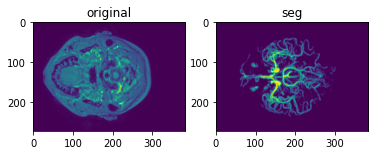

In [ ]:
plt.subplot(1,2,1); plt.imshow(t1s[0][:,:,150]); plt.title('original')
plt.subplot(1,2,2); plt.imshow(np.max(groundsegs[0][:,:,:],axis=2)); plt.title('seg')

In [ ]:
print("swapping axes...")

for i in range(len(groundsegs)):
  x,y,z = groundsegs[i].shape
  a= np.zeros(z)
  for j in  range(z):
    a[j]= np.sum(groundsegs[i][:,:,j])
  min = np.min(a.nonzero())
  max = np.max(a.nonzero())
  groundsegs[i] = np.swapaxes(groundsegs[i][int(x%32*0.5):-int(x%32*0.5),:,min:max],0,2)
  t1s[i] = np.swapaxes(t1s[i][int(x%32*0.5):-int(x%32*0.5),:,min:max],0,2)

print("t1 shape = " + str(t1s[i].shape) + " groundseg shape = " + str(groundsegs[i].shape))
print("expanding dimensions and tiling input...")
for i in range(len(groundsegs)):

  groundsegs[i] = np.expand_dims(groundsegs[i],axis=3)
  t1s[i] = np.expand_dims(t1s[i],axis=3)
  t1s[i] = np.tile(t1s[i],[1,1,1,3])
print("t1 shape = " + str(t1s[i].shape) + " groundseg shape = " + str(groundsegs[i].shape))


swapping axes...
t1 shape = (118, 384, 256) groundseg shape = (118, 384, 256)
expanding dimensions and tiling input...
t1 shape = (118, 384, 256, 3) groundseg shape = (118, 384, 256, 1)


In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/9Adamax', custom_objects={'iou_score':sm.metrics.iou_score,'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss})
model2 = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/18Adamax', custom_objects={'iou_score':sm.metrics.iou_score,'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss})

In [ ]:
pred1 = model1.predict(t1s[2])
pred2 = model2.predict(t1s[2])

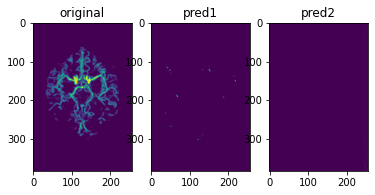

In [ ]:
plt.subplot(1,3,1); plt.imshow(np.max(groundsegs[2][:,:,:,0],axis=0)); plt.title('original')
plt.subplot(1,3,2); plt.imshow(np.max(pred1[:,:,:,0],axis=0)); plt.title('pred1')
plt.subplot(1,3,3); plt.imshow(np.max(pred2[:,:,:,0],axis=0)); plt.title('pred2')
plt.show()

TypeError: ignored

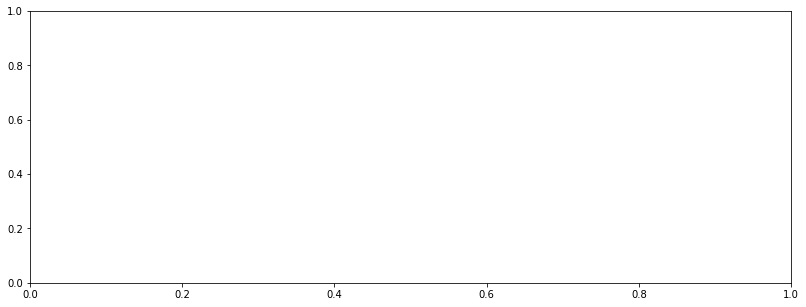

In [ ]:

# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()